# NLP Tutorial

## Feed-Forward Nets for NLP

In the previous lesson we used perceptrons but one major flaw in them is that they can't learn modestly nontirival patterns as seen below. It can also be described as an either-or (XOR) situation as the hyperplane cannot be a straight line.

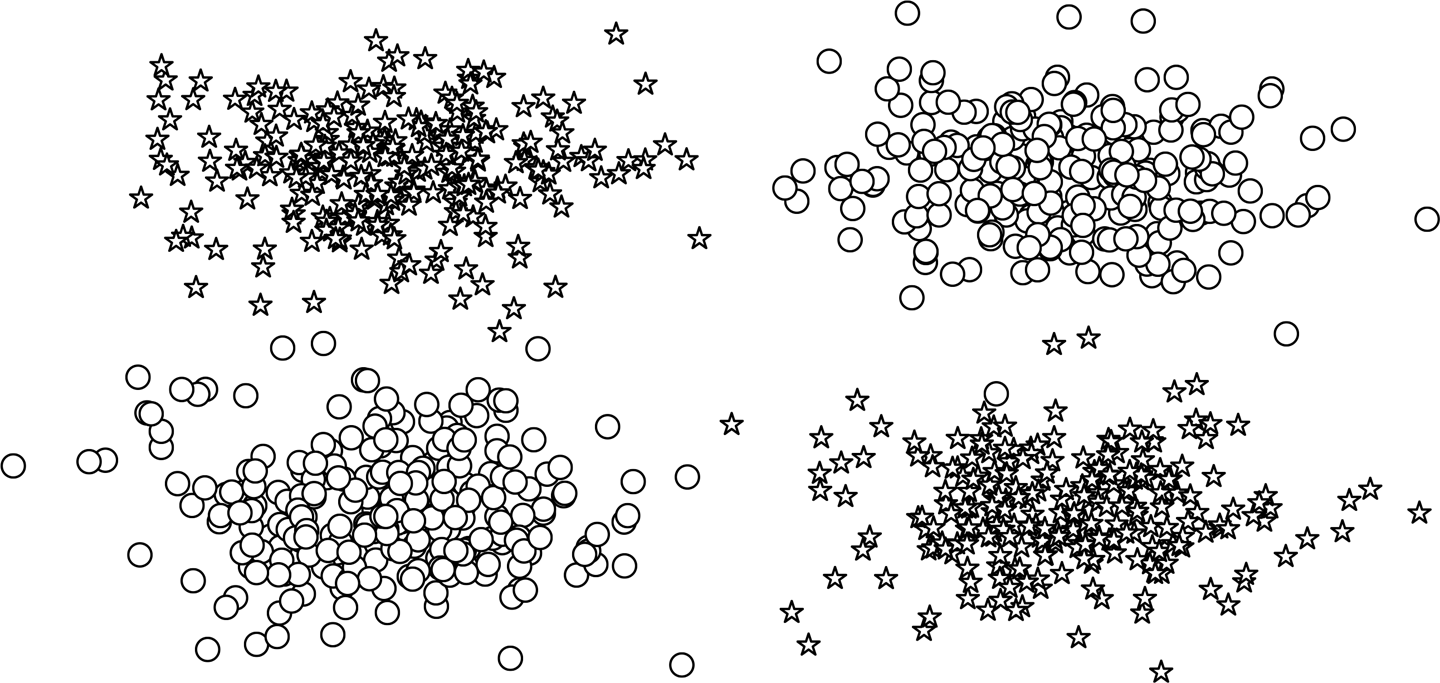

We will be going over multilayer perceptrons (MLP), and convolutional neural networks (CNN). 
MLP groups multiple perceptrons into one layer and stacks these layers together. CNNs is similar to windowed filters while processing digital signals.

### The Multilayer Perceptron


MLP is considered one of the most basic neural network building blocks. The simplest MLP is an extension to the perceptron that takes the data vector as input and computes a single output value. In an MLP, many perceptrons are grouped so that the output of a single layer is a new vector instead of a single output value. 

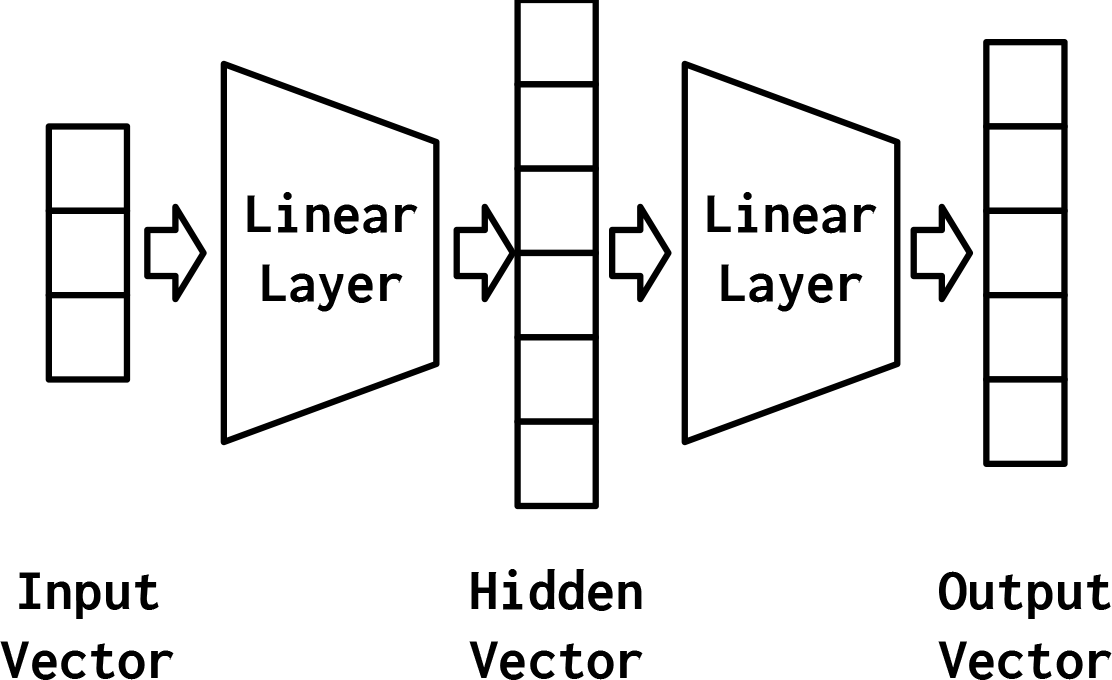

The simplest MLP is composed of three stages of representation and two Linear layers. The first stage is the input vector that is given to the model. The first Linear layer computes a hidden vector, in this case, the second stage of representation. With the hidden vector, the second Linear layer computes an output vector. The final hidden vector is mapped to the output vector using a combination of Linear layer and a nonlinearity.

By adding the second Linear layer, the model learns a linearly seperable representation, when a hyperplane can distinguish the data by which side of the hyperplane they are on.

#### XOR

Using the aforementioned example, there is quite the difference between using MLP and a perceptron. The perceptron model is on the right and the MLP model is on the left.

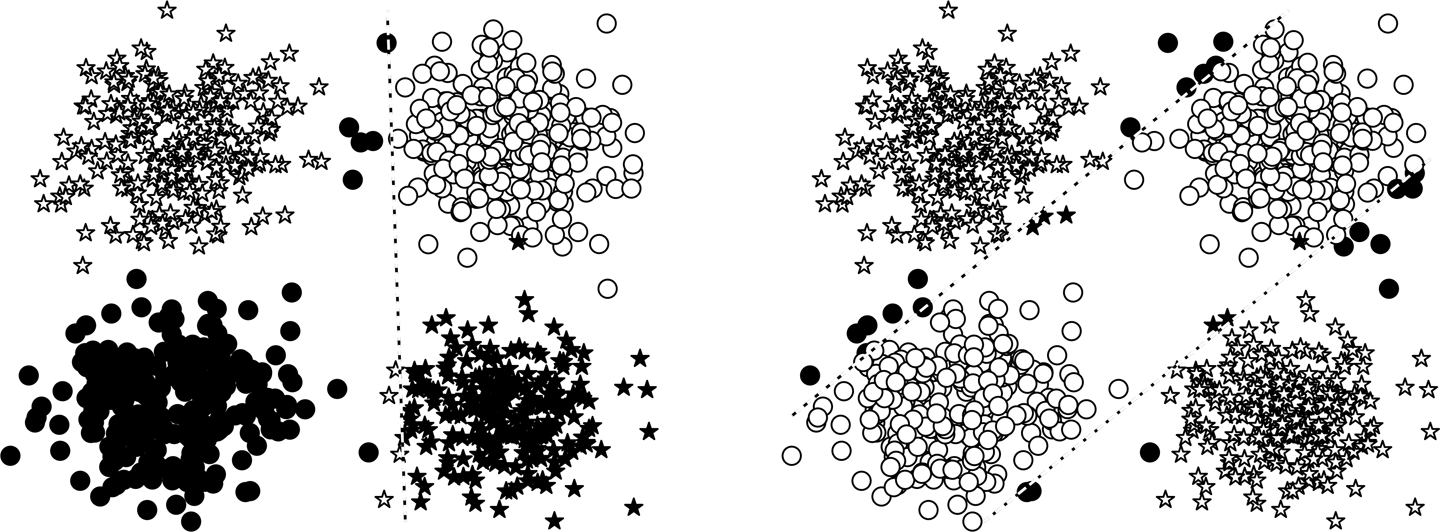

What seems to be 2 decision boundaries in the MLP model's graph is actually just one boundary! This is because the MLP changed the space that the data is on to its advantage as to be able to divide the dataset efficiently as seen below.

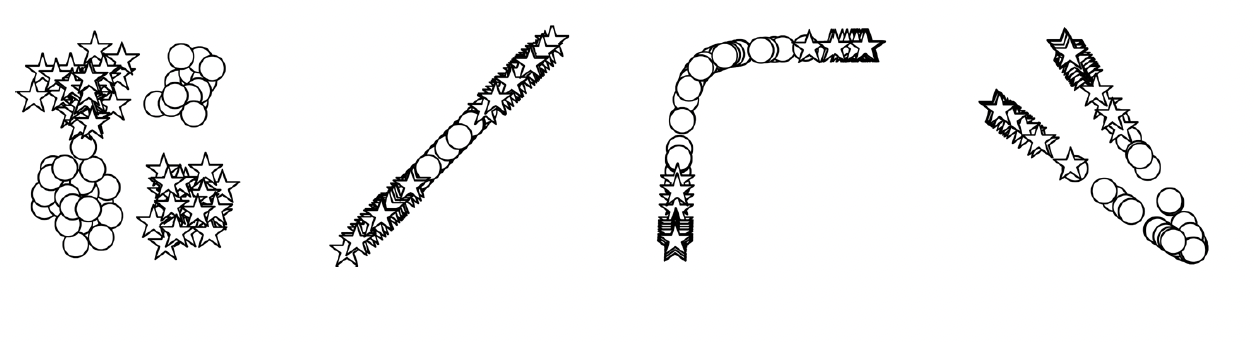

The graphs from left to right are 

(1) the input to the network 

(2) the output of the first linear module 

(3) the output of the first nonlinearity 

(4) the output of the second linear module. 

The output of the first linear module groups the circles and stars it finally leads to the output of the second linear module moving the data points to be linearly separable.

#### Implementing MLPs in PyTorch

We will be using PyTorch's Linear modules to create and add the extra layer. We are planning on making a Linear layer, connected to a hidden ReLU layer, and finally to another Linear Layer. We will only be creating the forward pass in backpropagation as PyTorch does the backwards pass under the hood.

In [7]:
import torch
import torch.nn as nn

def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
        input_dim (int): the size of the input vectors
        hidden_dim (int): the output size of the first Linear layer
        output_dim (int): the output size of the second Linear layer
        """
        
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x_in):
        """The forward pass of the MLP
            Args:
            x_in (torch.Tensor): an input data tensor
            x_in.shape should be (batch, input_dim)
            
            Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        
        intermediate = nn.functional.relu(self.fc1(x_in))
        output = self.fc2(intermediate)
        output = nn.functional.softmax(output, dim=1)
        return output
    
batch_size = 2 # number of samples input at once
input_dim = 3
hidden_dim = 100
output_dim = 4

# Initialize model
mlp = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
print(mlp)

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

y_output = mlp(x_input)
describe(y_output)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)
Type: torch.FloatTensor
Shape/size: torch.Size([2, 3])
Values: 
tensor([[0.4383, 0.2726, 0.0166],
        [0.5479, 0.5762, 0.3419]])
Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[0.2516, 0.2628, 0.2340, 0.2516],
        [0.2559, 0.2949, 0.2004, 0.2488]], grad_fn=<SoftmaxBackward0>)


Above we created a MLP class along with a small demo example and describe function. Upon instantiating the input, we always want to make sure that it really is random so we print it out so that we know that the model was actually trained and it wasn't a fluke. 

Our output however has added another column but that is not an error, that is because each row in the output corresponds to the batch dimension. The columns are the final feature vectors for each data point, otherwise known as a prediction vector. 

In order to convert the prediction vector into readable probabilities we must use the softmax activation function. Simply put, what the function does is it takes large positive values will result in higher probabilities, and lower negative values will result in smaller probabilities. This is why we do that to the output prior to returning it.

### Surname Classification with an MLP

We will now attempt to classify surnames to their country of origin. "Protected attributes" are attributes that include demographics and self-identifying attributes and we must be careful when handling said data.

The implementation and training should remain largely the same from waht we did with the perceptrons in the previous lesson. We will take the dataset, do some preprocessing, turn the strings into vecorized minibatches with the Vocabulary, Vectorizer, and DataLoader classes. One main difference is that we will be doing multiclass outputs and what their loss functions will look like. Finally we will do an evaluation using a "test" portion of the dataset.

#### Surnames Dataset

The first property is that it is fairly imbalanced as the top three classes are: 27% English, 21% Russian, and 14% Arabic; the remaining 15 nationalities have decreasing frequency which is endemic to language. The second property a relationship between nationality of origin and surname spelling. We will be implementing the SurnameDataset in a very similar manner to that of ReviewDataset in the last lesson. 

#### Vocabulary, Vectorizer, and DataLoader

The Vocabulary class should remain nearly the same between ReivewDataset and SurnameDataset. In Review, we did not need to treat each character as its own but in Surname, we have to as there are no words, only a surname. To solve this, in the SurnameVectorizer we no longer ned to remove whitespace like we did in ReviewVectorizer.

In [19]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [9]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [10]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [11]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname

        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding 
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

#### The SurnameClassifier Model & Training Routine

Like the XOR example we used earlier, we wil be using 2 Linear Layers and the softmax activation. The softmax function is actually optional but we use it to see the probabilities. The reason that it is optional is as previously seen, softmax is cross-entropy loss which is desirable but it is wasteful and not numerically stable at times.

The training being done remains the same as it is standard to do this type of model training.

In [14]:
class SurnameClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector
    
    
    
    
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)


Expanded filepaths: 
	surname_mlp/vectorizer.json
	surname_mlp/model.pth
Using CUDA: False


#### Instantiation and Training Loop

The Instantiation Process is rather simple with the addition of making the model accessible again. The training loop is the same as aforementioned but we will be using different keys to get the data from the dictionary.

In [32]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    reload_from_files=True,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	surname_mlp/vectorizer.json
	surname_mlp/model.pth
Using CUDA: False


In [35]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab))



classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)



train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                 total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                 total=dataset.get_num_batches(args.batch_size), 
                          position=1, leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
               total=dataset.get_num_batches(args.batch_size), 
               position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

Reloading!


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

#### Model Evaluation

Now let's see how accurate our model is.

In [29]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [30]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.8011637306213377;
Test Accuracy: 45.4375


### Convolutional Neural Networks

Let us try and replicate what we did with a CNN instead! CNNs are well suited to detect spatial substructure because they have a small # of weights that scan the input data tensors which then in turn produce output tensors what represent subtructure presence.

#### CNN Hyperparameters

There are different design decisions within a CNN. One is to use a single "kernel" and apply to the input matrix as seen below. The first step we can see the input and the "kernel". The next step we see how the kernel applies itself to the input. As a result, we get the output matrix.

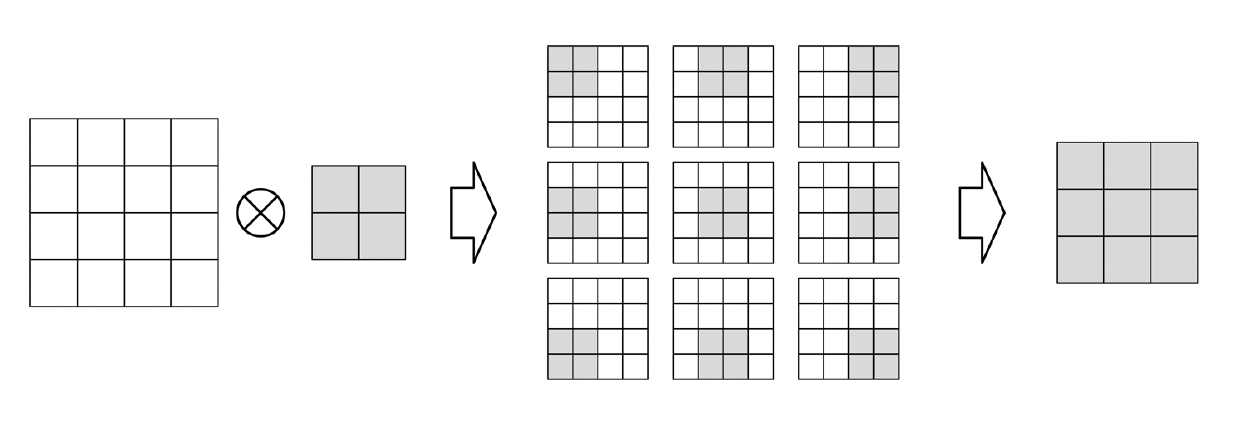

#### Dimension of The Convolution Operation

In the image above we did a 2D convolution but there can be one for any number of dimensions. Most NLP convolutions are 1D as 2D is used for images and 3D for videos. 

#### Channels

A Channel is the feature dimension along each input point. Images have 3, one for each color in RGB. In text however, the number of channels is the vocabulary size.

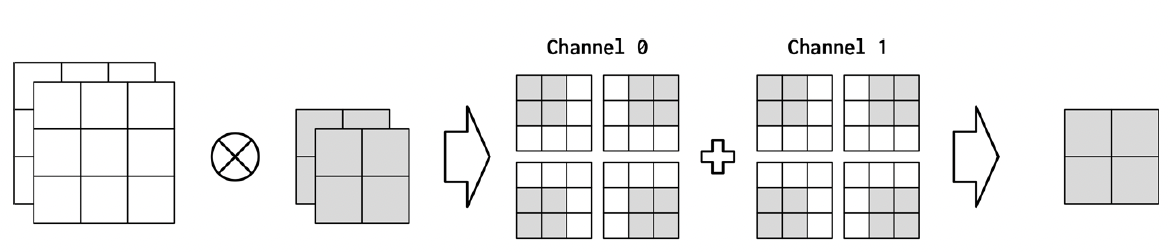

This image shows what wil happen when there are 2 channels going through a CNN. they will each have their own kernel and be added afterwards.

This image shows what may happen when there are 2 kernels but just 1 input tensor. The result is a 2D output tensor.

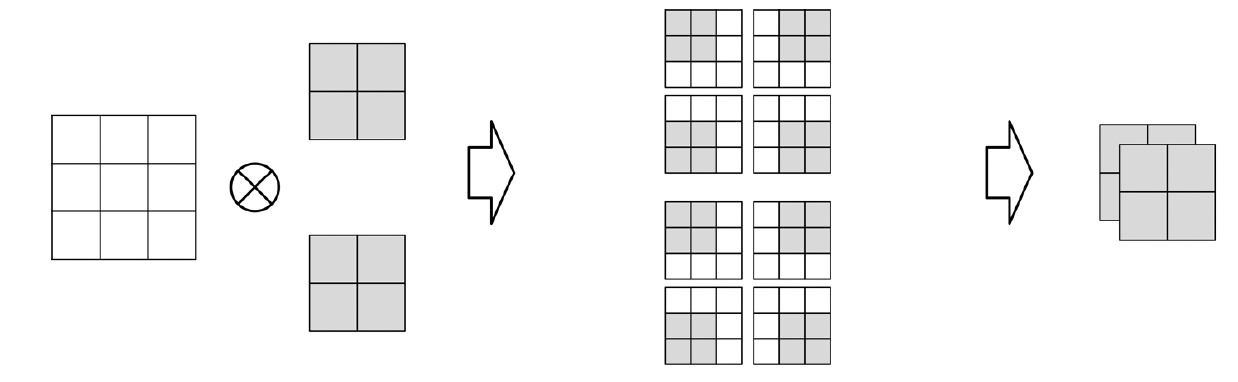

Choosing the right number of channels is also a difficulty. A rule of thumb is not to shrink the channel number by more than 2 times from one layer to the next.

#### Kernel Size

The larger the kernel is, the smaller the output size is. This is similar to the n-grams problem as the smaller the kernel is, smaller patters can be picked up.

#### Stride

Stride is the step size between convolutions. If stride is equal to the kernel size, then kernal computations do not need to overlap. Instead, if stride is 1, then the kernels are maximally overlapping.

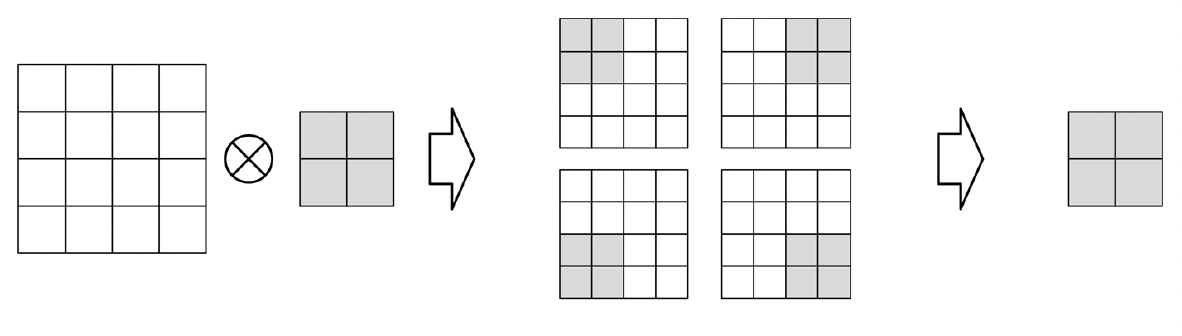

#### Adding

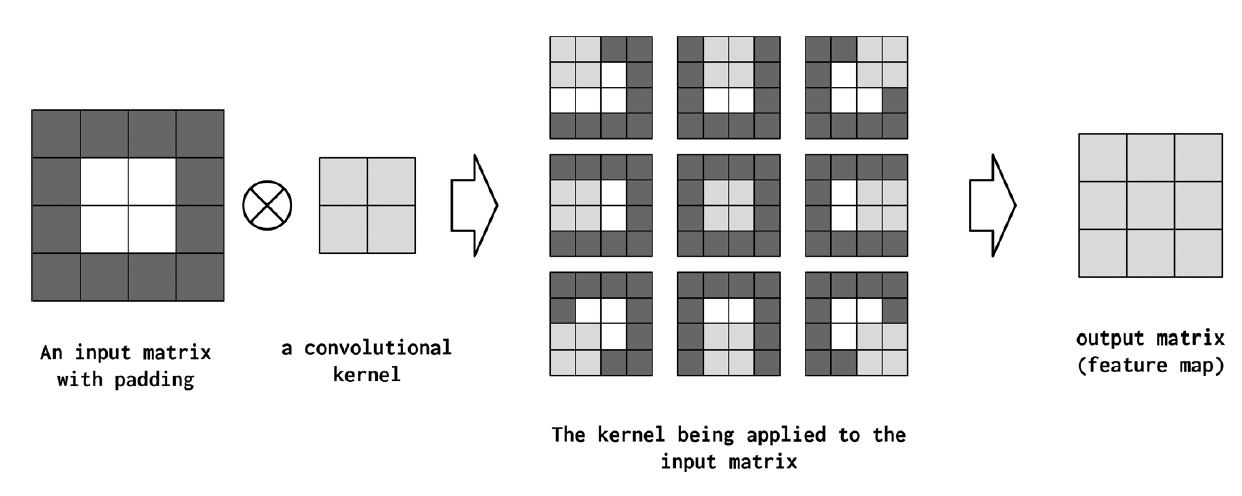

We can artificially add 1 row/column/etc to the tensor as to pad it. This will allow for more convolutions all without compromising the desired kernel size, stride, or dilation.

#### Dilation

Dilating a CNN affects how the kernel affects the input matrix. Another way to describe dilating is that we are striding the kernel itself so that there are "holes" when it applies itself to the matrix.

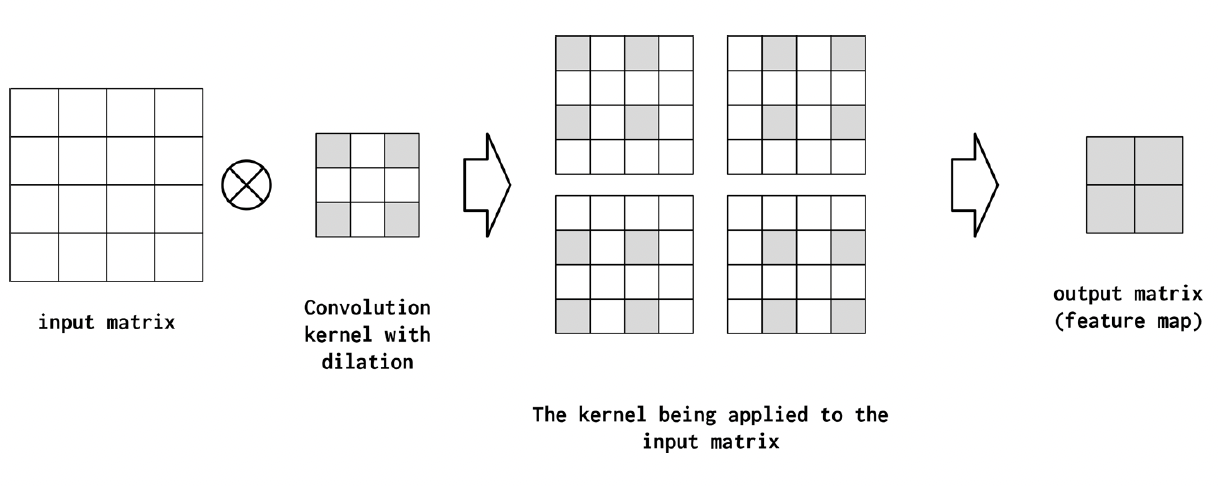

### Surname Classification With CNN

Let us use the previous dataset from the last example but use a CNN instead of a MLP. We'll now go into what that will entail

#### SurnameDataset Class

The date and the class can remain largely the same except for one difference. Instead of a collapsed one-hot vector, we will be using a matrix of one-hot vectors due to the nature of the CNN model.

#### Vectorizer

The vectorizer in the CNN model will be different than from the MLP model due to the difference in input. Therefore, we will be needing to change a few things in order to seamlessly add it together. 

#### Updated SurnameClassfier

Since CNN's system is totally different, we will be adding different things to it as well. We will be using PyTorch's Sequential model which has the linear sequence of operations and ELU, a ReLU alternative that exponentiates values below 0.

#### Training and Evaluation

The training and evaluation should remain the same as what we did with the MLP model

In [36]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [37]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1
        
        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(), 
                'max_surname_length': self._max_surname_length}

In [38]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            name_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [39]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels, 
                      out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        features = self.convnet(x_surname).squeeze(dim=2)
       
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [40]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

In [44]:
def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

args = Namespace(
    # Data and Path information
    surname_csv="surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="surname_cnn",
    # Model hyper parameters
    hidden_dim=100,
    num_channels=256,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    dropout_p=0.1,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	surname_cnn/vectorizer.json
	surname_cnn/model.pth
Using CUDA: False


In [45]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab), 
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

classifer = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

In [46]:
epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/60 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

In [47]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.818398783604304;
Test Accuracy: 56.77083333333333


### Miscellaneous Topics in CNNs

#### Pooling

Pooling is a way to summarize a high dimensional, and possibly redundant, feature map into a lower dimensional one. It is an arithmetic operator that is applied over a a local reagion in a feature map. This image displays a pooling operation.

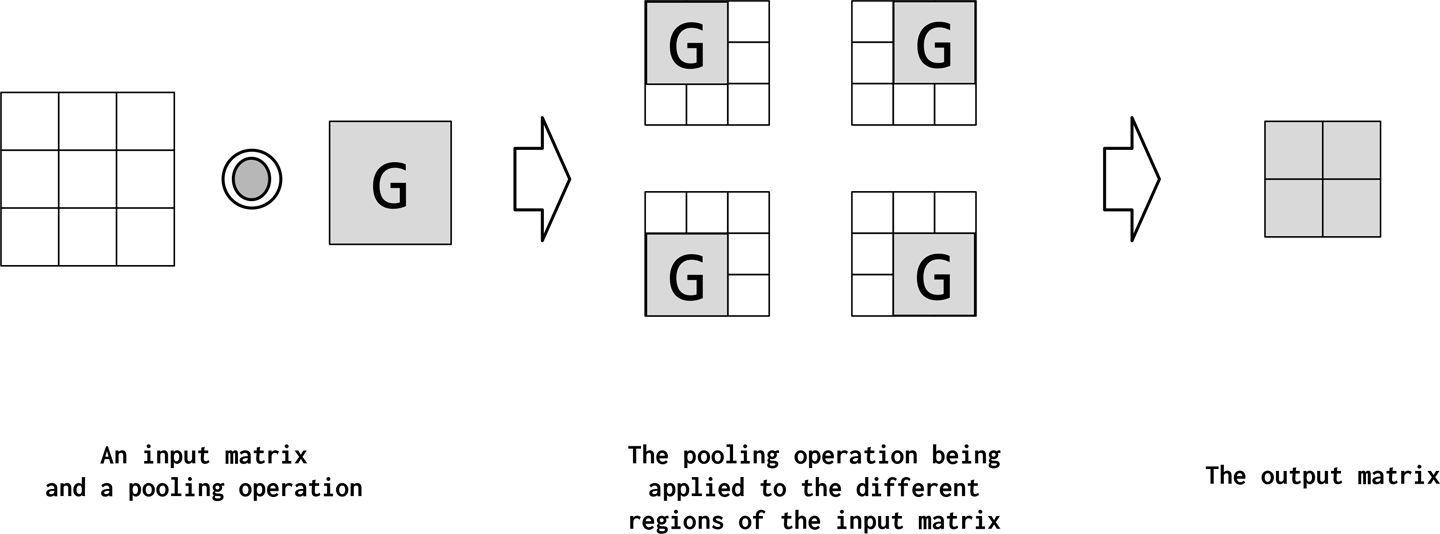

#### Batch Normalization

Batch Normalization applies a transformation to the output of a CNN by scaling the activations to have zero mean and unit variance. The mean and variance values it uses for the Z-transform are updated per batch such that fluctuations in any single batch won’t shift or affect it too much which decreases model sensitivity to parameter initialization and learning rate tuning.

#### Network-in-Network Connections 

Network-in-network (NiN) connections are convolutional kernels with kernel_size=1 so the convolution acts like a fully connected linear layer
across the channels which helps mapping shallower feature maps.

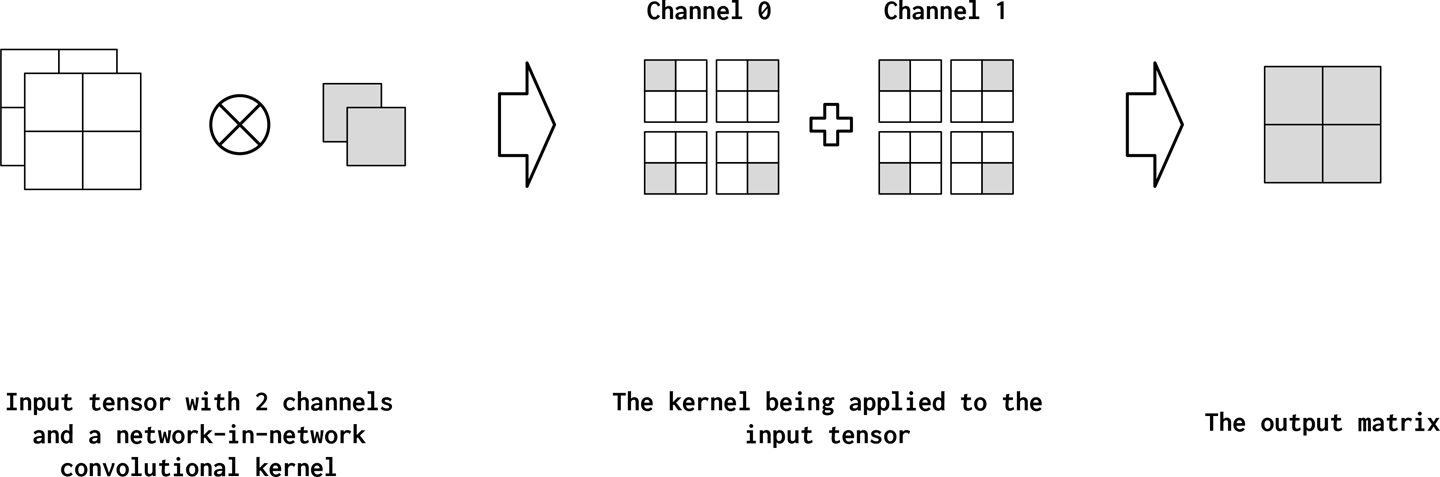

#### Residual Connections/Block

Recently with technological capabilities rising, we have been able to add more and more layers. One of the things that has come out of. This is called a residual/skip connection:

    output = conv(input) + input
    
However, in order to go through with this, the sizes need to both be the same so if needed, additional padding is given.
    
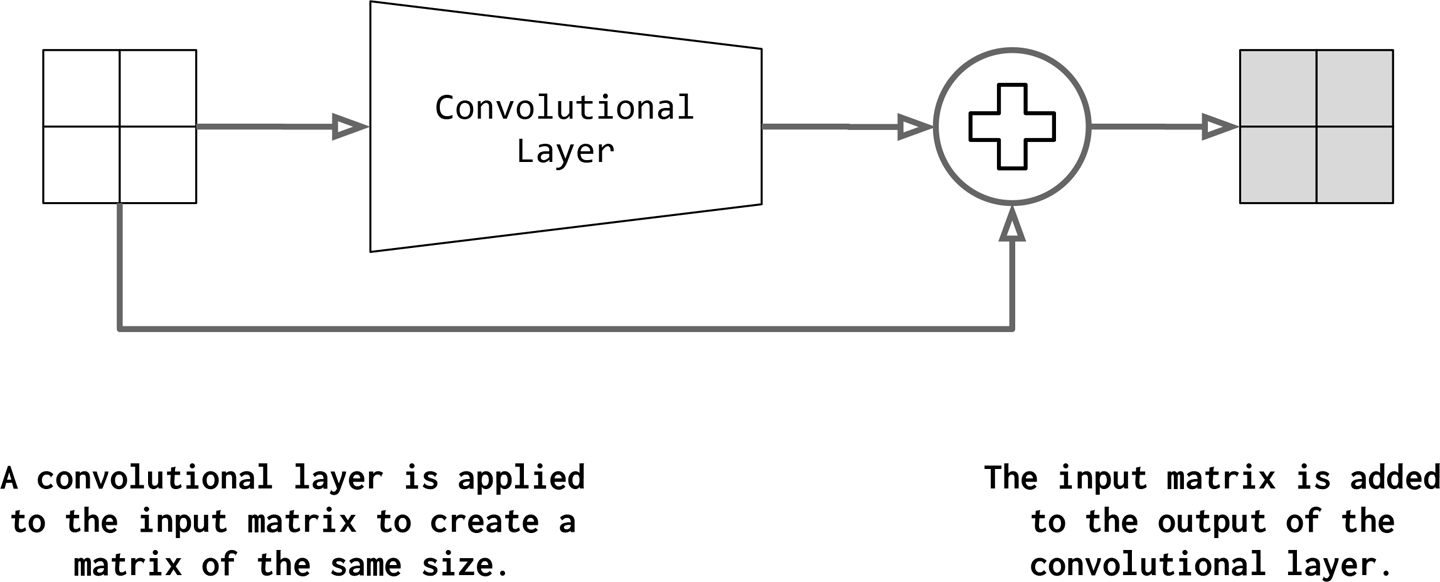